<a href="https://www.kaggle.com/code/daanishhindustani/tb-squeezenet?scriptVersionId=156000400" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import pathlib
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Conv2D, ReLU, concatenate, Dropout,AvgPool2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score, FBetaScore
import os
import shutil
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# **Retrieving Data**

## *Main Dir Url*

In [2]:
url = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

In [3]:
data_dir = pathlib.Path(url)

## *NUMBER of imgs*

In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

4200


## *Elements in the dir*

In [5]:
elements = os.listdir(url)
print(elements)

['Normal.metadata.xlsx', 'Tuberculosis', 'README.md.txt', 'Tuberculosis.metadata.xlsx', 'Normal']


# Classes

In [6]:
img_type= {
    'Normal' : list(data_dir.glob('Normal/*.png')),
    'Tuberculosis' : list(data_dir.glob('Tuberculosis/*.png'))
}

## *Img samples*

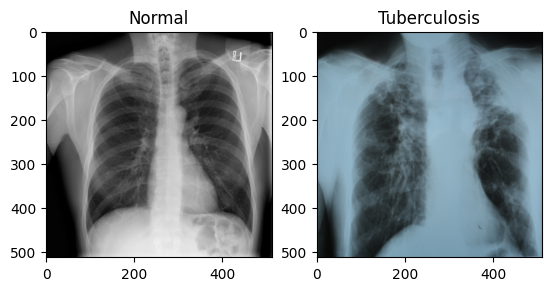

In [7]:
def img_plot_original():
    fig, axs = plt.subplots(1,2)
    i = 0
    for key, value in img_type.items():
        img = mpimg.imread(str(img_type[key][3]))
        axs[i].imshow(img)
        axs[i].set_title(key)
        i+=1
img_plot_original()  
    

## *Original dataset split*

([<matplotlib.patches.Wedge at 0x7cdc75f37f40>,
 [Text(-0.9526279098330698, 0.5500000594609756, 'Normal'),
  Text(0.9526278840857079, -0.5500001040567061, 'Tuberculosis')],
 [Text(-0.5196152235453108, 0.3000000324332594, '83.3%'),
  Text(0.5196152095012951, -0.30000005675820324, '16.7%')])

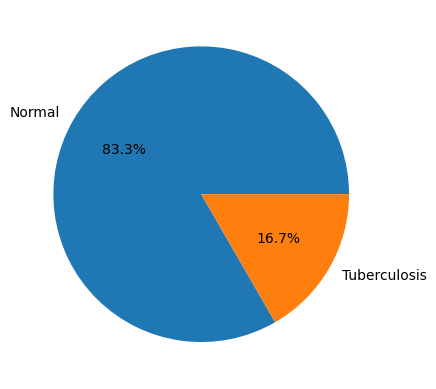

In [8]:

labels = 'Normal', 'Tuberculosis'
sizes = [len(img_type['Normal']), len(img_type['Tuberculosis'])]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')


In [9]:
len(img_type['Normal'])

3500

In [10]:
len(img_type['Tuberculosis'])

700

# Reducing Data 

## *Making TESTING DIR*

In [11]:
os.mkdir('Xray-Test-Data')

In [12]:
xrayTestUrl = '/kaggle/working/Xray-Test-Data'

In [13]:
data_dir_test = pathlib.Path(xrayTestUrl)

## *TB TESTING DIR*

In [14]:
directoryTestTb = "Test-TB-Xray" 
parent_dir = xrayTestUrl
pathTestTB = os.path.join(parent_dir, directoryTestTb) 
os.mkdir(pathTestTB) 

## *Making NORMAL TESTING DIR*

In [15]:
directoryTestNM = "Test-NM-Xray"
  
parent_dir = xrayTestUrl

pathTestNM = os.path.join(parent_dir, directoryTestNM) 
os.mkdir(pathTestNM) 

## *NUMBER OF NM TESTING SAMPLES*

In [16]:
normalTestImg = img_type['Normal'][1000:1101]

## *NUMBER OF TB TESTING SAMPLES*

In [17]:
tbTestImg = img_type['Tuberculosis'][600:]

## *COPYING SAMPLES INTO TESTING TB AND NM DIR*

In [18]:
destination_directory_tb = '/kaggle/working/Xray-Test-Data/Test-TB-Xray'
for img in tbTestImg:
    shutil.copy(img, destination_directory_tb)

In [19]:
destination_directory_NM = '/kaggle/working/Xray-Test-Data/Test-NM-Xray'
for img in normalTestImg:
    shutil.copy(img, destination_directory_NM)

# ----Making Training/VAL DIR 

## *TRAINING DIR*

In [20]:
os.mkdir('Xray-Data')

In [21]:
xrayUrl = '/kaggle/working/Xray-Data'

## *NM/TB TRAINING DIR*

In [22]:

directoryTB = "TB-Xray"
directoryNM = 'NM-Xray'
  
parent_dir = "/kaggle/working/Xray-Data"

pathTB = os.path.join(parent_dir, directoryTB) 
os.mkdir(pathTB) 
pathNM = os.path.join(parent_dir, directoryNM) 
os.mkdir(pathNM) 

In [23]:
#shutil.rmtree('')

## *TB/NM TRAINING SAMPLES*

In [24]:
normal_imgs = img_type['Normal'][:600]

made 900 NM to imporve percison, model generlized to false values
mode 650

In [25]:
len(normal_imgs)

600

In [26]:
tb_imgs = img_type['Tuberculosis'][:600]

In [27]:
len(tb_imgs)

600

In [28]:
img_type= {
    'Normal' : list(data_dir.glob('Normal/*.png')),
    'Tuberculosis' : list(data_dir.glob('Tuberculosis/*.png'))
}

## *COPYING TRAINING SAMPLES INTO CORROSPONDING TRAING DIR*

In [29]:
destination_directory_tb = '/kaggle/working/Xray-Data/TB-Xray'
for img in tb_imgs:
    shutil.copy(img, destination_directory_tb)
    

In [30]:
destination_directory_nm = '/kaggle/working/Xray-Data/NM-Xray'
for img in normal_imgs:
    shutil.copy(img, destination_directory_nm)

# ----Visualizing New Data

In [31]:
data_dir = pathlib.Path("/kaggle/working/Xray-Data")


In [32]:
img_type= {
    'Normal' : list(data_dir.glob('NM-Xray/*.png')),
    'Tuberculosis' : list(data_dir.glob('TB-Xray/*.png'))
}

In [33]:
len(img_type['Tuberculosis'])

600

([<matplotlib.patches.Wedge at 0x7cdc75bdd870>,
 [Text(6.735557395310444e-17, 1.1, 'Normal'),
  Text(-2.0206672185931328e-16, -1.1, 'Tuberculosis')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%')])

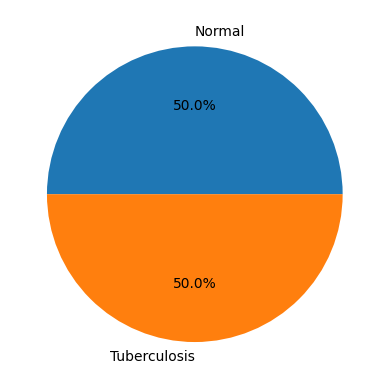

In [34]:
labels = 'Normal', 'Tuberculosis'
sizes = [len(img_type['Normal']), len(img_type['Tuberculosis'])]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')


# Augmenting Data

In [35]:
img_height = 64
img_width = 64
batch_size = 16

## *TRAINING*

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2
)


In [37]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='training',
    seed=123
    )

Found 960 images belonging to 2 classes.


In [38]:
traing_set_len = len(train_generator)
print(traing_set_len)

60


## *VALIDATION*

In [39]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [40]:
val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='validation',
    seed=123
    )

Found 240 images belonging to 2 classes.


In [41]:
val_set_len = len(val_generator)
print(val_set_len)

15


## *TESTING*

In [42]:
test_generator = val_datagen.flow_from_directory(
    data_dir_test,
    target_size = (img_height, img_width),
    class_mode = 'binary',
    )

Found 201 images belonging to 2 classes.


In [43]:
test_set_len = len(test_generator)
print(test_set_len)


7


## *AUGMENTED TRAINING SAMPLE*

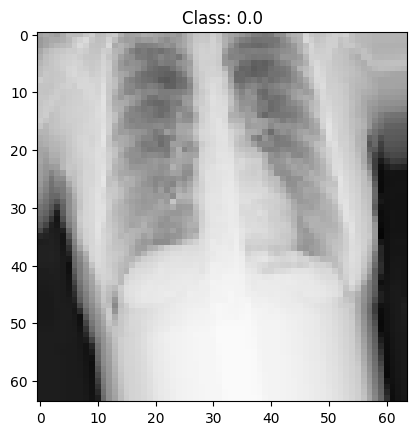

In [44]:
images, labels = next(train_generator)
# Plot one image from the batch
plt.imshow(images[0])
plt.title(f"Class: {labels[0]}")
plt.show()

## *TRAING/VALIDATION/TESTING*

([<matplotlib.patches.Wedge at 0x7cdc75932410>,
 [Text(0.923301960552699, 0.5979243176519436, 'Validation'),
  Text(-1.048736003975903, -0.3318927446701039, 'Training'),
  Text(1.0606788854346743, -0.29147950527105265, 'Testing')],
 [Text(0.5036192512105631, 0.3261405369010601, '18.3%'),
  Text(-0.5720378203504926, -0.181032406183693, '73.2%'),
  Text(0.578552119328004, -0.1589888210569378, '8.5%')])

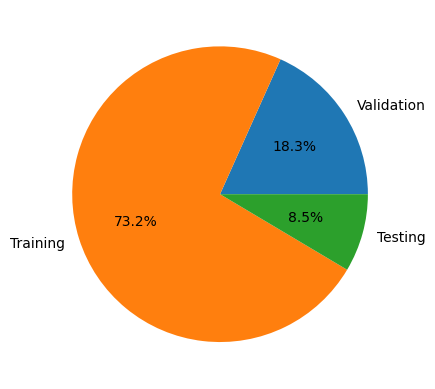

In [45]:
labels = 'Validation', 'Training', 'Testing'
sizes = [val_set_len, traing_set_len, test_set_len]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# SQUEEZNET ARCITECTURE

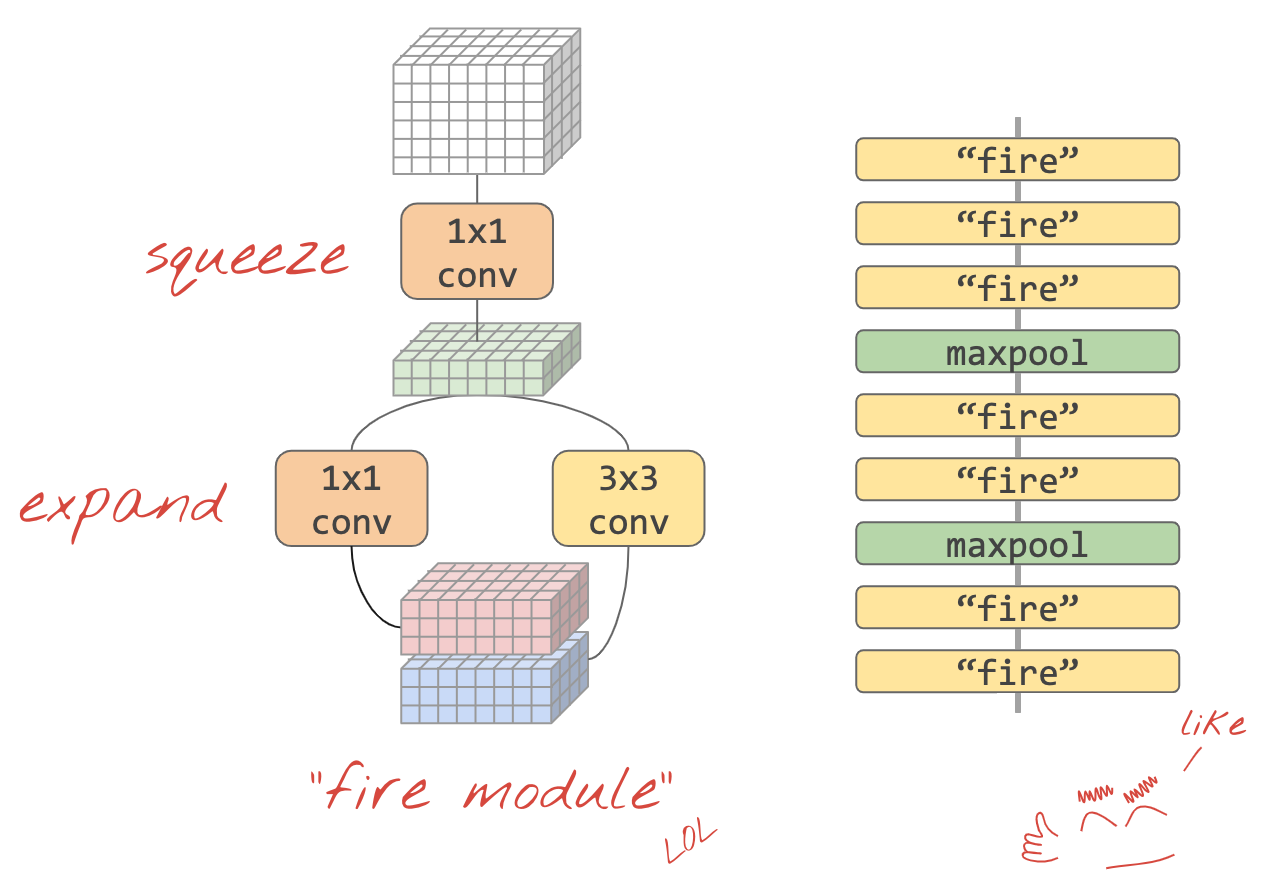

## *FIREMODE*

In [46]:
def fireMode(x, s1, e1, e3):
    sx1 = Conv2D(filters=s1, kernel_size=1, activation='relu', padding='same')(x)
    sx1 = BatchNormalization()(sx1)
    ex1 = Conv2D(filters=e1, kernel_size=1, activation='relu', padding='same')(sx1)
    ex1 = BatchNormalization()(ex1)
    ex3 = Conv2D(filters=e3, kernel_size=3, activation='relu', padding='same')(sx1)
    ex3 = BatchNormalization()(ex3)
    return concatenate([ex1, ex3])

## *MAIN NETWORK*

In [47]:
def squeezNet(input_size, classes):
    
    x = Input(shape=input_size)
    
    # Entry block
    y = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    y = BatchNormalization()(y)

    # Fire modules
    y = fireMode(y, 12, 24, 24)
    y = BatchNormalization()(y)
    y = GlobalAveragePooling2D()(y)
    y = BatchNormalization()(y)
    # Dense layers
    y = layers.Dense(128, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = BatchNormalization()(y)
    # Output layer 
    y = layers.Dense(1, activation='sigmoid')(y)

    model = Model(inputs=x, outputs=y)
    return model
      

In [48]:
model = squeezNet((64,64,3), 1)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 12)           396       ['batch_normalization[0][0

## *F1 SCORE*

In [50]:
def f1_score(y_true, y_pred):
    # Calculate true positives, false positives, and false negatives
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    actual_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    # Calculate precision and recall
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1


## *TRAINING*

In [51]:
opt = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy',Precision(), Recall(),f1_score])


In [52]:
history = model.fit(train_generator, steps_per_epoch=traing_set_len, epochs=10, validation_data=val_generator, validation_steps=test_set_len)

Epoch 1/10
60/60 [==============================] - ETA: 0s - batch: 29.5000 - size: 16.0000 - loss: 0.7049 - accuracy: 0.6052 - precision: 0.6110 - recall: 0.5792 - f1_score: 0.5947

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60/60 [==============================] - 10s 140ms/step - batch: 29.5000 - size: 16.0000 - loss: 0.7049 - accuracy: 0.6052 - precision: 0.6110 - recall: 0.5792 - f1_score: 0.5947 - val_loss: 0.6950 - val_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 9s 150ms/step - batch: 29.5000 - size: 16.0000 - loss: 0.5516 - accuracy: 0.7323 - precision: 0.7575 - recall: 0.6833 - f1_score: 0.7087 - val_loss: 0.6942 - val_accuracy: 0.4464 - val_precision: 1.0000 - val_recall: 0.0159 - val_f1_score: 0.0190
Epoch 3/10
60/60 [==============================] - 9s 149ms/step - batch: 29.5000 - size: 16.0000 - loss: 0.4924 - accuracy: 0.7625 - precision: 0.8014 - recall: 0.6979 - f1_score: 0.7337 - val_loss: 0.6758 - val_accuracy: 0.4911 - val_precision: 1.0000 - val_recall: 0.0952 - val_f1_score: 0.1595
Epoch 4/10
60/60 [==============================] - 9s 150ms/step - batch: 29.5000 - size: 16.0000 - 

## *RESULTS*

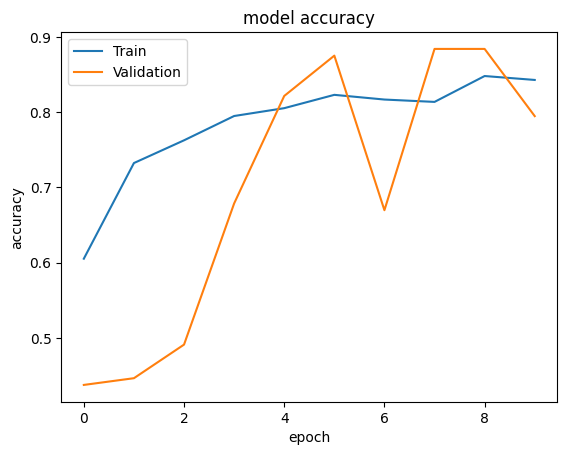

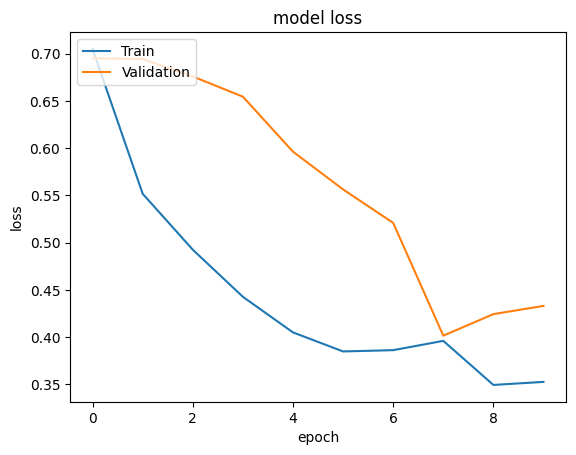

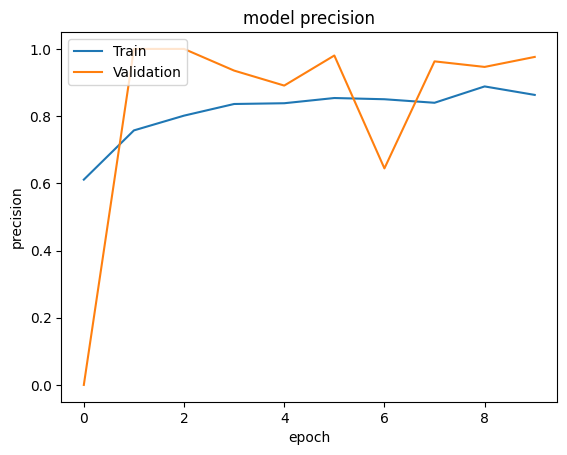

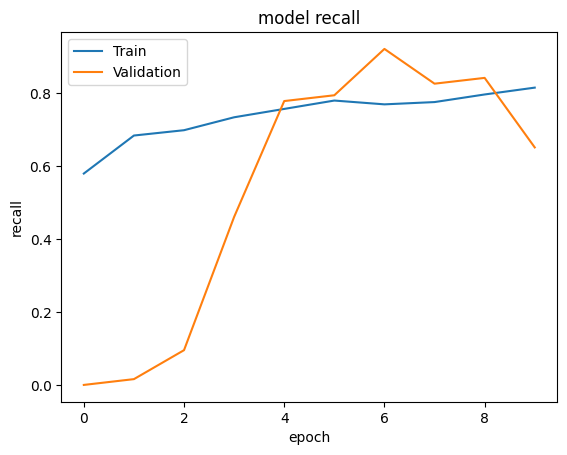

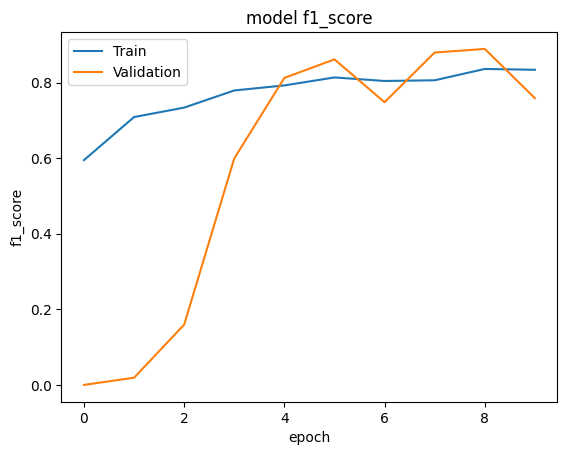

In [53]:
# summarize accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize percison
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize recall
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# TESTING USAGE 

In [54]:
results = model.evaluate(test_generator)

In [55]:
def results_test_data():
    print(f"Loss: {results[0]}")
    print(f"Accuracy: {results[1]}")
    print(f"Percision: {results[2]}")
    print(f"Recall: {results[3]}")
    print(f"F1_Score: {results[4]}")

In [56]:
results_test_data()

Loss: 0.3181500477450235
Accuracy: 0.8805969953536987
Percision: 1.0
Recall: 0.7599999904632568
F1_Score: 0.8173469305038452


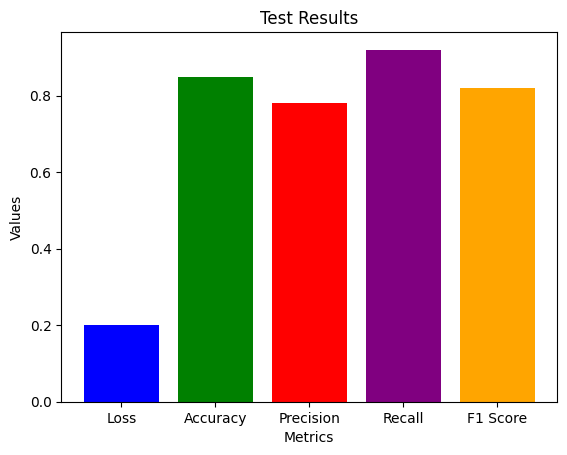

In [57]:
def results_test_data(results):
    labels = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = results[:5]  # Assuming results is a list with at least 5 elements

    # Bar graph
    plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Test Results')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.show()

# Example usage
results = [0.2, 0.85, 0.78, 0.92, 0.82]
results_test_data(results)

In [58]:
predicted_values = model.predict(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [59]:
acutal_test_values = []
for i in range(7):
    lst = test_generator[i][1]
    for num in lst:
        acutal_test_values.append(num)
        

In [60]:
predicted_values = (predicted_values >= 0.5).astype(int)
conf_matrix = confusion_matrix(acutal_test_values, predicted_values)

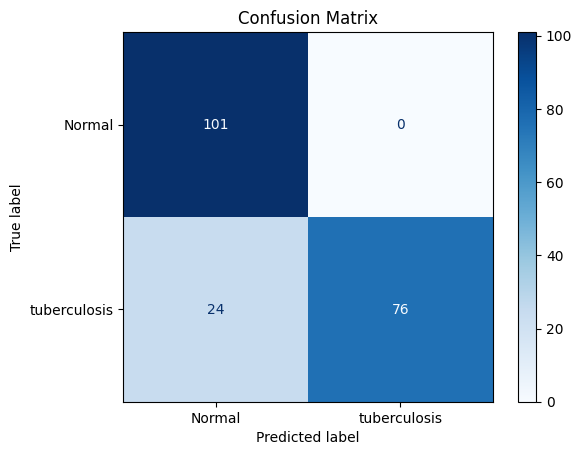

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', "tuberculosis"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [62]:
sum = 0
for i in range(2):
    for j in range(2):
        sum += conf_matrix[i][j]

In [63]:
truth = conf_matrix[0][0] + conf_matrix[1,1]

In [64]:
false = conf_matrix[0,1] + conf_matrix[1,0]

# PRESTON